In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from keras.models import load_model
from os.path import join
from bridgescaler import load_scaler
from sealsml.data import Preprocessor
%matplotlib inline

In [2]:
ls /glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/2024-06-05_1033/

scaler_2024-06-05_1033.json
train_files.csv
train_transformer_test_PL.yaml
transformer_leak_loc_2024-06-05_1033.keras
transformer_leak_loc_model_hist_2024-06-05_1033.csv
transformer_leak_loc_output_2024-06-05_1033_train.nc
transformer_leak_loc_output_2024-06-05_1033_val.nc
validation_files.csv


In [74]:
model_path = "/glade/derecho/scratch/jsauer/SEALS_TRAINING/TEST_TRANSFORMER/2024-06-05_1033/"

In [3]:
mod = load_model(join(model_path, "transformer_leak_loc_2024-06-05_1033.keras")

2024-06-19 15:00:53.771990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79084 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


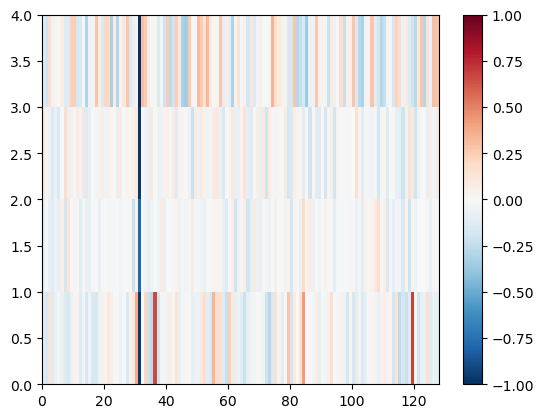

In [64]:
plt.pcolormesh(mod.decoder_hidden.get_weights()[0], cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

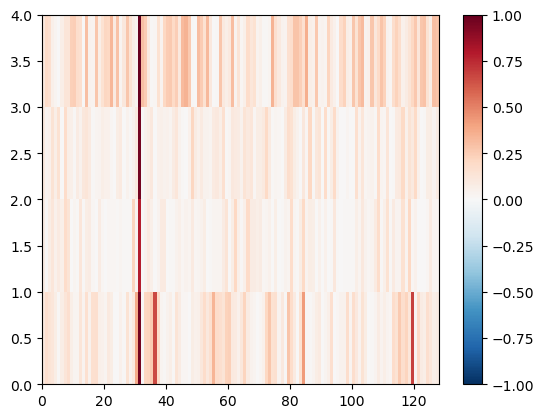

In [65]:
plt.pcolormesh(np.abs(mod.decoder_hidden.get_weights()[0]), cmap="RdBu_r", vmin=-1, vmax=1)
plt.colorbar()

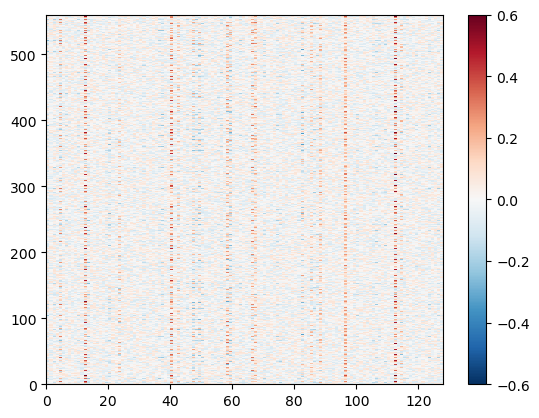

In [68]:
plt.pcolormesh(mod.encoder_hidden.get_weights()[0], cmap="RdBu_r", vmin=-0.6, vmax=0.6)
plt.colorbar()

In [69]:
mod.encoder_hidden.get_weights()[0].shape

(560, 128)

In [21]:
mod.n_conv_layers

3

In [71]:
val_ds = xr.open_dataset(join(model_path, "transformer_leak_loc_output_2024-06-05_1033_val.nc"))

In [72]:
val_ds

<xarray.Dataset> Size: 101MB
Dimensions:        (sample: 221184, pot_leak_locs: 38)
Dimensions without coordinates: sample, pot_leak_locs
Data variables:
    targets        (sample, pot_leak_locs) int64 67MB ...
    leak_loc_pred  (sample, pot_leak_locs) float32 34MB ...

In [75]:
val_files = pd.read_csv(join(model_path, "validation_files.csv"))

In [78]:
val_files

,Unnamed: 0,validation_files
0,0,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
1,1,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
2,2,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
3,3,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
4,4,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
...,...,...
187,187,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
188,188,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
189,189,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...
190,190,/glade/derecho/scratch/jsauer/SEALS_TRAINING/T...


In [79]:
val_file_ds = xr.open_dataset(val_files["validation_files"][0])

In [89]:
val_file_ds["decoder_input"][1, :, 0, :4, 0]

<xarray.DataArray 'decoder_input' (pot_leak: 38, variable: 4)> Size: 608B
array([[ 1.321864e+02,  8.134962e-01, -5.815703e-01,  2.322275e-02],
       [ 1.494197e+02,  6.004785e-01, -7.996409e-01,  2.551345e-02],
       [ 1.658471e+02,  8.470191e-01, -5.315624e-01,  6.773988e-03],
       [ 1.366400e+02,  9.377999e-01, -3.471763e-01,  2.789671e-02],
       [ 5.550225e+01,  9.990042e-01, -4.461456e-02,  2.023532e-02],
       [ 1.625646e+02,  8.664306e-01, -4.992975e-01,  6.910757e-03],
       [ 1.911001e+02,  7.673534e-01, -6.412244e-01,  5.878892e-03],
       [ 1.435218e+02,  9.993442e-01, -3.621041e-02,  7.827605e-03],
       [ 1.391483e+02,  9.471680e-01, -3.207379e-01,  2.739448e-02],
       [ 3.517101e+01,  9.790339e-01,  2.036971e-01,  3.191649e-02],
       [ 1.916377e+02,  7.538005e-01, -6.571034e-01,  5.862401e-03],
       [ 1.621496e+02,  8.792080e-01, -4.764382e-01,  6.928442e-03],
       [ 8.151380e+01,  6.149375e-01, -7.885758e-01,  2.123644e-02],
       [ 1.243835e+02,  8.536454e-01, -5.208546e-01,  1.392013e-02],
       [ 7.334337e+01,  4.014122e-01, -9.158975e-01,  1.531522e-02],
       [ 1.170000e+02,  9.985618e-01, -5.361243e-02,  9.601734e-03],
       [ 1.662242e+02,  6.869521e-01, -7.267027e-01,  1.430908e-02],
       [ 1.639947e+02,  9.780800e-01, -2.082296e-01,  6.850499e-03],
       [ 1.908514e+02,  7.405074e-01, -6.720482e-01,  5.886552e-03],
       [ 1.300817e+02,  8.283071e-01, -5.602744e-01,  1.828282e-02],
       [ 1.200260e+02,  9.994619e-01, -3.280199e-02,  9.359695e-03],
       [ 1.529722e+02,  5.815171e-01, -8.135342e-01,  2.492157e-02],
       [ 1.125044e+02,  9.980459e-01, -6.248613e-02,  9.985345e-03],
       [ 7.631023e+01,  6.000926e-01, -7.999306e-01,  1.472000e-02],
       [ 1.771334e+02,  6.726230e-01, -7.399853e-01,  9.775545e-03],
       [ 1.597694e+02,  8.872310e-01, -4.613254e-01,  7.031654e-03],
       [ 1.450000e+02,  9.985618e-01, -5.361243e-02,  7.747814e-03],
       [ 5.147815e+01,  9.819965e-01, -1.888989e-01,  2.181592e-02],
       [ 1.657362e+02,  8.575936e-01, -5.143279e-01,  6.778519e-03],
       [ 1.470213e+02,  9.975058e-01, -7.058461e-02,  7.641307e-03],
       [ 7.955658e+01,  6.780398e-01, -7.350251e-01,  1.411954e-02],
       [ 4.022747e+01,  8.153241e-01, -5.790049e-01,  2.791027e-02],
       [ 1.363616e+02,  7.856392e-01, -6.186849e-01,  2.251231e-02],
       [ 1.342433e+02,  9.273108e-01, -3.742923e-01,  2.839412e-02],
       [ 1.340988e+02,  8.004953e-01, -5.993390e-01,  2.289185e-02],
       [ 5.886000e+01,  9.865338e-01, -1.635572e-01,  4.036172e-02],
       [ 1.686483e+02,  6.728460e-01, -7.397825e-01,  1.026729e-02],
       [ 5.108815e+01,  9.936904e-01, -1.121575e-01,  5.993380e-02]],
      dtype=float32)
Coordinates:
  * variable  (variable) <U12 192B 'ref_distance' 'ref_azi_sin' ... 'ref_elv'
Dimensions without coordinates: pot_leak

In [99]:
p = Preprocessor()
encoder_data, decoder_data, leak_location, leak_rate = p.load_data(val_files["validation_files"][0:3])
p.load_scaler(join(model_path, "scaler_2024-06-05_1033.json"))
scaled_encoder_data, encoder_mask = p.preprocess(encoder_data, fit_scaler=False)
scaled_decoder_data, decoder_mask = p.preprocess(decoder_data, fit_scaler=False)

In [128]:
decoder_data

<xarray.DataArray 'decoder_input' (sample: 3456, pot_leak: 38, target_time: 1,
                                   variable: 8, mask: 2)> Size: 8MB
dask.array<concatenate, shape=(3456, 38, 1, 8, 2), dtype=float32, chunksize=(1152, 38, 1, 8, 2), chunktype=numpy.ndarray>
Coordinates:
  * variable  (variable) <U12 384B 'ref_distance' 'ref_azi_sin' ... 'w' 'q_CH4'
Dimensions without coordinates: sample, pot_leak, target_time, mask

In [106]:
preds = mod.predict((scaled_encoder_data, scaled_decoder_data))

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [113]:
preds_shuffled_set = []
for v in range(4):
    print(v)
    scaled_decoder_shuffled = np.copy(scaled_decoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_decoder_shuffled[:, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_data, scaled_decoder_shuffled), batch_size=2048)
    preds_shuffled_set.append(preds_shuffled)

0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [171]:
decoder_pred_diffs = np.zeros(4)
for v in range(4):
    decoder_pred_diffs[v] = np.sqrt(np.mean((preds - preds_shuffled_set[v]) ** 2))
    print(decoder_data["variable"][v].values, decoder_pred_diffs[v])
    

ref_distance 0.39487823843955994
ref_azi_sin 0.016443531960248947
ref_azi_cos 0.016615018248558044
ref_elv 0.39291343092918396


In [134]:
preds_shuffled_enc = []
for v in range(8):
    print(v)
    scaled_encoder_shuffled = np.copy(scaled_encoder_data)
    rng = np.random.default_rng()
    rng.shuffle(scaled_encoder_shuffled[:, :, :, v], axis=0)
    preds_shuffled = mod.predict((scaled_encoder_shuffled, scaled_decoder_data), batch_size=2048)
    preds_shuffled_enc.append(preds_shuffled)

0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [174]:
encoder_pred_diffs = np.zeros(8)
for v in range(8):
    encoder_pred_diffs[v] = np.sqrt(np.mean((preds - preds_shuffled_enc[v]) ** 2))
    print(encoder_data["variable"][v].values, encoder_pred_diffs[v])

ref_distance 0.0012983562191948295
ref_azi_sin 0.0014495754148811102
ref_azi_cos 0.00023980320838745683
ref_elv 0.0013468009419739246
u 0.0007550697191618383
v 0.0005295256851240993
w 0.0014901496469974518
q_CH4 0.00013432827836368233


(array([ 224100.,  245100.,  226800.,  225600.,  223800.,  230700.,
         241500.,  226200.,  237000.,  234600.,  225000.,  236400.,
         238800.,  244200.,  231900.,  234900.,  243300.,  179700.,
              0., 1034400.]),
 array([5.00500493e-04, 4.55205217e-02, 9.05405432e-02, 1.35560557e-01,
        1.80580586e-01, 2.25600600e-01, 2.70620614e-01, 3.15640628e-01,
        3.60660672e-01, 4.05680686e-01, 4.50700700e-01, 4.95720714e-01,
        5.40740728e-01, 5.85760772e-01, 6.30780756e-01, 6.75800800e-01,
        7.20820844e-01, 7.65840828e-01, 8.10860872e-01, 8.55880857e-01,
        9.00900900e-01]),
 <BarContainer object of 20 artists>)

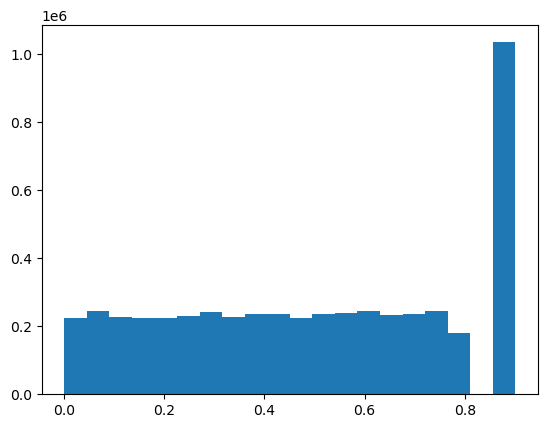

In [195]:
plt.hist(scaled_encoder_data[:, :, :, 2].ravel(), bins=20)

In [186]:
scaled_encoder_data.shape

(3456, 5, 300, 8)

(array([215., 301., 300., 296., 334., 382., 398., 401., 550., 279.]),
 array([-0.39802709, -0.32535496, -0.25268283, -0.18001069, -0.10733856,
        -0.03466643,  0.0380057 ,  0.11067783,  0.18334997,  0.2560221 ,
         0.32869422]),
 <BarContainer object of 10 artists>)

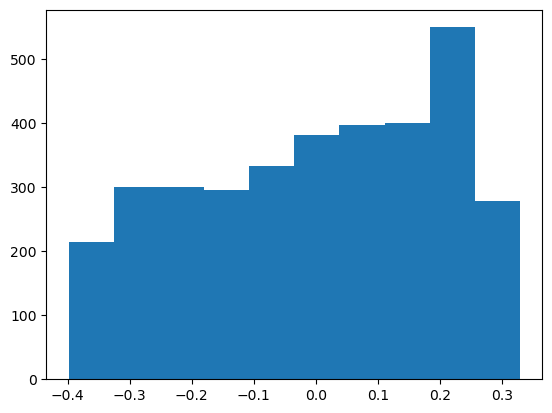

In [168]:
plt.hist(scaled_decoder_data[:, :, 0][leak_location == 1] - scaled_decoder_data[:, :, 0].mean(axis=1))


In [176]:
pdp_inputs = np.arange(0, 1.05, 0.05)
pdp_vals = np.zeros(pdp_inputs.shape)
for p, pdpi in enumerate(pdp_inputs):
    print(p)
    scaled_decoder_data_pdp = np.copy(scaled_decoder_data)
    scaled_decoder_data_pdp[:, :, 3] = pdpi
    pdp_preds = mod.predict((scaled_encoder_data, scaled_decoder_data_pdp), batch_size=1024)
    pdp_vals[p] = pdp_preds.mean()

0
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
14
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
15
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
17
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
18
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
19
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


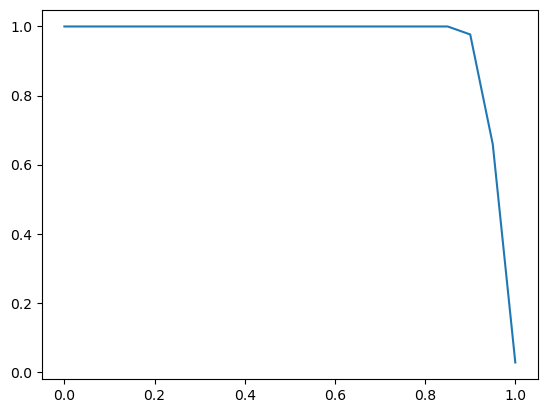

In [177]:
plt.plot(pdp_inputs, pdp_vals)